# Extract data from .sol files

This workbook can be used to extract physical paramaters from a folder a .sol files

## Import stuff

In [1]:
import pandas as pd
from src.cmwp_tools import extractDataDir
import matplotlib.pyplot as plt

## Extract data from solution files

This code extracts data from CMWP .sol files

In [2]:
data_df = extractDataDir('/home/rhys/Documents/CMWP-210315/DESY_202107/sam1a/*.sol', ellipticity=1)

Parsing 68 solution files...


/home/rhys/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


Parsed 67 solution files succesfully                                                                    
"*** END" not present in 1                                                                     
Done!


In [3]:
# Print dataframe
data_df
#data_df.style.set_sticky(axis="filename") #need pandas 1.3.0

,filename,wssr,rho,rho_new,rho_neg,rho_pos,a1,a1_neg,a1_pos,a2,...,b,b_neg,b_pos,c,c_neg,c_pos,a_lat,c_lat,a_err,c_err
0,y_-0.166_z_12.619.sol,144265.0,45.220100,54.813889,6.961364,5.974714,1.327630,0.734179,0.439446,-0.669552,...,12.731500,0.875927,0.912849,0.694497,0.018543,0.012918,3.231346,5.149110,0.000094,0.000355
1,y_-0.166_z_12.621.sol,256652.0,6.142460,9.221999,2.877264,1.272636,0.992272,0.815648,0.796794,-0.277112,...,25.303600,1.103237,3.188254,0.587863,0.023985,0.008465,3.231451,5.149842,0.000078,0.000094
2,y_-0.166_z_12.623.sol,1593670.0,13.241800,18.774996,3.398274,0.322930,0.799896,0.311160,0.186376,-0.291739,...,58.853298,2.395329,1.518415,0.266258,0.007695,0.022312,3.232650,5.148724,0.000080,0.000169
3,y_-0.166_z_12.625.sol,7085190.0,0.428642,0.616909,0.093770,0.040716,0.193147,0.343802,0.504114,-0.163725,...,78.135002,2.961317,4.664660,0.162830,0.060736,0.019702,3.231670,5.149912,0.000062,0.000084
4,y_-0.166_z_12.627.sol,7116650.0,0.393120,0.542723,0.064584,0.134052,0.066070,0.369990,0.358098,-0.175534,...,78.481400,5.462305,3.233434,0.131416,0.027466,0.047441,3.230737,5.150062,0.000078,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,y_0.500_z_12.643.sol,5275760.0,0.294854,0.413222,0.065289,0.063636,0.025838,0.284216,0.475416,-0.155129,...,87.508301,4.777953,4.410418,0.144879,0.041435,0.024340,3.230640,5.151209,0.000059,0.000117
63,y_0.500_z_12.647.sol,6736990.0,0.532583,0.688247,0.082590,0.128702,-0.287704,0.268428,0.397032,-0.162512,...,85.792099,2.256332,7.052111,0.174229,0.078403,0.024044,3.230758,5.150989,0.000065,0.000164
64,y_0.500_z_12.651.sol,8029930.0,0.601355,0.730668,0.103755,0.106678,-0.607793,0.314229,0.281408,-0.149121,...,81.489899,2.607677,5.174609,0.136588,0.063240,0.008496,3.230292,5.151174,0.000057,0.000105
65,y_0.500_z_12.655.sol,7220310.0,0.315112,0.439299,0.069849,0.072045,-0.064812,0.261192,0.289062,-0.142447,...,84.312500,2.124675,3.448381,0.119259,0.042933,0.008944,3.230221,5.151305,0.000076,0.000244


## Pull out z and y values from filename

In [4]:
data_df[['f2', 'y', 'f4', 'zs']] = data_df['filename'].str.split('_',expand=True)               # Split by '_'
data_df[['z', 'no']] = data_df['zs'].str.split('.s',expand=True)                                # Split by '.s'
data_df.drop(['f2', 'filename', 'f4', 'zs', 'no'], axis=1, inplace=True)                        # Clear un-needed columns

# Rearrange to put y and z first
cols = data_df.columns.tolist()
data_df=data_df[cols[-2:] + cols[:-2]]

In [5]:
# Print dataframe
data_df

,y,z,wssr,rho,rho_new,rho_neg,rho_pos,a1,a1_neg,a1_pos,...,b,b_neg,b_pos,c,c_neg,c_pos,a_lat,c_lat,a_err,c_err
0,-0.166,12.619,144265.0,45.220100,54.813889,6.961364,5.974714,1.327630,0.734179,0.439446,...,12.731500,0.875927,0.912849,0.694497,0.018543,0.012918,3.231346,5.149110,0.000094,0.000355
1,-0.166,12.621,256652.0,6.142460,9.221999,2.877264,1.272636,0.992272,0.815648,0.796794,...,25.303600,1.103237,3.188254,0.587863,0.023985,0.008465,3.231451,5.149842,0.000078,0.000094
2,-0.166,12.623,1593670.0,13.241800,18.774996,3.398274,0.322930,0.799896,0.311160,0.186376,...,58.853298,2.395329,1.518415,0.266258,0.007695,0.022312,3.232650,5.148724,0.000080,0.000169
3,-0.166,12.625,7085190.0,0.428642,0.616909,0.093770,0.040716,0.193147,0.343802,0.504114,...,78.135002,2.961317,4.664660,0.162830,0.060736,0.019702,3.231670,5.149912,0.000062,0.000084
4,-0.166,12.627,7116650.0,0.393120,0.542723,0.064584,0.134052,0.066070,0.369990,0.358098,...,78.481400,5.462305,3.233434,0.131416,0.027466,0.047441,3.230737,5.150062,0.000078,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.500,12.643,5275760.0,0.294854,0.413222,0.065289,0.063636,0.025838,0.284216,0.475416,...,87.508301,4.777953,4.410418,0.144879,0.041435,0.024340,3.230640,5.151209,0.000059,0.000117
63,0.500,12.647,6736990.0,0.532583,0.688247,0.082590,0.128702,-0.287704,0.268428,0.397032,...,85.792099,2.256332,7.052111,0.174229,0.078403,0.024044,3.230758,5.150989,0.000065,0.000164
64,0.500,12.651,8029930.0,0.601355,0.730668,0.103755,0.106678,-0.607793,0.314229,0.281408,...,81.489899,2.607677,5.174609,0.136588,0.063240,0.008496,3.230292,5.151174,0.000057,0.000105
65,0.500,12.655,7220310.0,0.315112,0.439299,0.069849,0.072045,-0.064812,0.261192,0.289062,...,84.312500,2.124675,3.448381,0.119259,0.042933,0.008944,3.230221,5.151305,0.000076,0.000244


## Calculate depth from edge

This takes a list of all y positions (calculated from the data list above) 
and a list of the corresponsing z positions at the edge of the sample, 
to make a new column called 'depth', which is the distance of the pattern away from the sample edge in microns

In [6]:
# These are the unique y positions
data_df['y'] = pd.to_numeric(data_df['y'], downcast="float")
unique = data_df['y'].unique()
print(unique)

[-0.166 -0.5    0.167  0.5  ]


In [7]:
##########################################
# Here, define the edge (z value) for each y
##########################################

edges = [12.623, 12.623, 12.623, 12.621]
print(edges)

[12.623, 12.623, 12.623, 12.621]


In [8]:
if len(unique) != len(edges):
    raise Exception('Unique and edges should be the same length')
    
# Make a new column 'depth'
data_df['depth'] = data_df['y'].copy()

cols = data_df.columns.tolist()
data_df=data_df[cols[-1:] + cols[:-1]]

for col in data_df.columns:
    data_df[col] = pd.to_numeric(data_df[col], downcast="float")

cols = data_df.columns.tolist()

df2 = pd.DataFrame({'unique':unique, 'edges':edges})

rename_dict = df2.set_index('unique').to_dict()['edges']


In [9]:
data_df['depth'].replace(rename_dict, inplace=True)
data_df['depth'] = data_df['z'] - data_df['depth']
data_df['depth'] = data_df['depth'] * 1000

In [10]:
data_df

,depth,y,z,wssr,rho,rho_new,rho_neg,rho_pos,a1,a1_neg,...,b,b_neg,b_pos,c,c_neg,c_pos,a_lat,c_lat,a_err,c_err
0,-3.999710,-0.166,12.619,144265.0,45.220100,54.813889,6.961364,5.974714,1.327630,0.734179,...,12.731500,0.875927,0.912849,0.694497,0.018543,0.012918,3.231346,5.149110,0.000094,0.000355
1,-1.999855,-0.166,12.621,256652.0,6.142460,9.221999,2.877264,1.272636,0.992272,0.815648,...,25.303600,1.103237,3.188254,0.587863,0.023985,0.008465,3.231451,5.149842,0.000078,0.000094
2,0.000000,-0.166,12.623,1593670.0,13.241800,18.774996,3.398274,0.322930,0.799896,0.311160,...,58.853298,2.395329,1.518415,0.266258,0.007695,0.022312,3.232650,5.148724,0.000080,0.000169
3,1.999855,-0.166,12.625,7085190.0,0.428642,0.616909,0.093770,0.040716,0.193147,0.343802,...,78.135002,2.961317,4.664660,0.162830,0.060736,0.019702,3.231670,5.149912,0.000062,0.000084
4,3.999710,-0.166,12.627,7116650.0,0.393120,0.542723,0.064584,0.134052,0.066070,0.369990,...,78.481400,5.462305,3.233434,0.131416,0.027466,0.047441,3.230737,5.150062,0.000078,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,21.999359,0.500,12.643,5275760.0,0.294854,0.413222,0.065289,0.063636,0.025838,0.284216,...,87.508301,4.777953,4.410418,0.144879,0.041435,0.024340,3.230640,5.151209,0.000059,0.000117
63,26.000023,0.500,12.647,6736990.0,0.532583,0.688247,0.082590,0.128702,-0.287704,0.268428,...,85.792099,2.256332,7.052111,0.174229,0.078403,0.024044,3.230758,5.150989,0.000065,0.000164
64,29.999733,0.500,12.651,8029930.0,0.601355,0.730668,0.103755,0.106678,-0.607793,0.314229,...,81.489899,2.607677,5.174609,0.136588,0.063240,0.008496,3.230292,5.151174,0.000057,0.000105
65,33.999443,0.500,12.655,7220310.0,0.315112,0.439299,0.069849,0.072045,-0.064812,0.261192,...,84.312500,2.124675,3.448381,0.119259,0.042933,0.008944,3.230221,5.151305,0.000076,0.000244


## Plot

This plots dislocation density, <a> loop fraction, M paramater and lattice paramaters as a function of depth from sample edge

(46.490386199951175, 46.65245513916015)

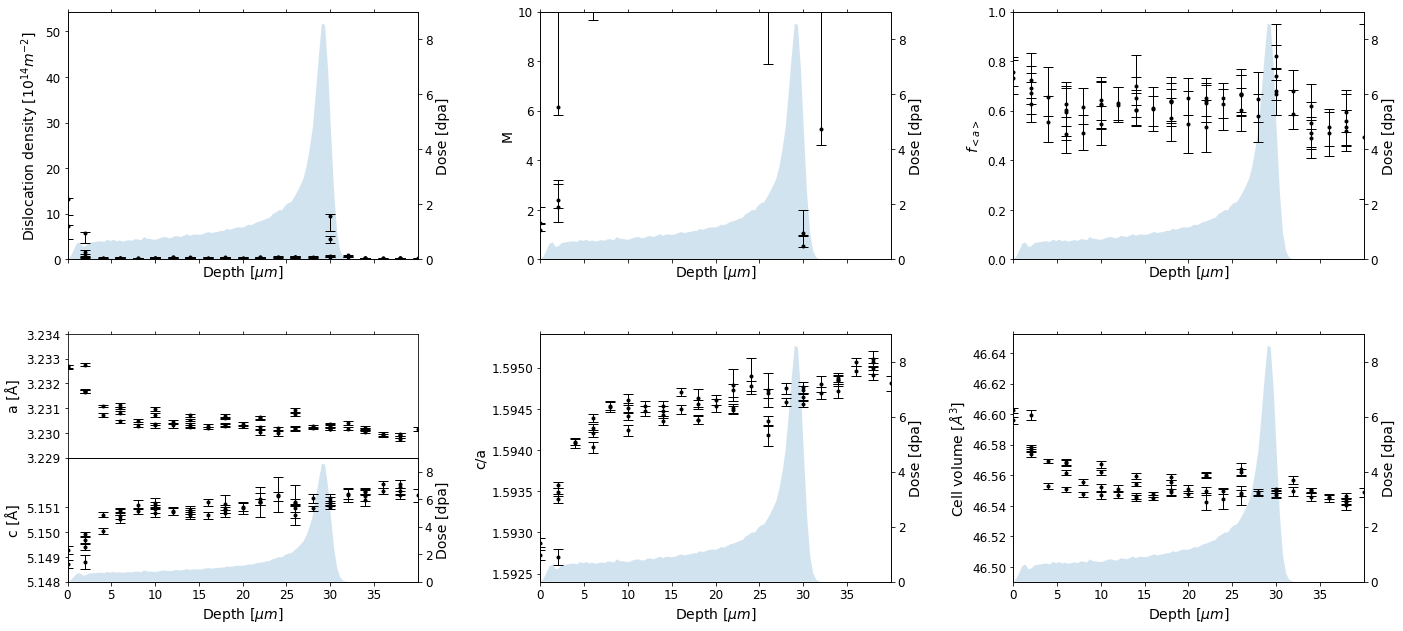

In [11]:
depth, dpa = np.loadtxt('data/srim.txt')

fig, ((ax, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,9), sharex=True)
fig.subplots_adjust(left=0.06, right=0.96, top=0.98, bottom=0.1, hspace=0.3, wspace = 0.35)
axes = [ax, ax2, ax3, ax4, ax5, ax6]

max_x = np.max(data_df['depth'])
x=data_df['depth']; a=data_df['a_lat']; c=data_df['c_lat']; a_err=data_df['a_err']; c_err=data_df['c_err'];

# Common settings for all axes
for sax in axes:
    sax.set_xlabel('Depth [${\mu}m$]', fontsize=14)
    sax.tick_params(axis='both', which='major', labelsize=12)
    sax.set_xlim(0, max_x)
    #sax.vlines(line_x, ymin=0, ymax=300, linestyles='dashed', alpha=0.3)
    sax.xaxis.set_ticks_position('both')
    
    sec = sax.twinx()
    sec.fill(depth, np.array(dpa), alpha=0.2)
    sec.set_xlim(0, max_x)
    sec.set_ylim(0)
    sec.set_ylabel('Dose [dpa]', fontsize=14)
    
    sec.tick_params(axis='both', which='major', labelsize=12)

#### dislocation density
    
ax.errorbar(x=x, y=data_df['rho'], yerr = [data_df['rho_neg'],data_df['rho_pos']],  marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
ax.set_ylabel('Dislocation density [$10^{14} m^{-2}$]', fontsize=14)
ax.set_zorder(sec.get_zorder()+1); ax.patch.set_visible(False);
ax.set_ylim(0)

#### m

ax2.errorbar(x=x, y=data_df['m'], yerr = [data_df['m_neg'],data_df['m_pos']], marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
ax2.set_ylabel('M', fontsize=14)
ax2.set_ylim(0, 10)
ax2.set_zorder(sec.get_zorder()+1); ax2.patch.set_visible(False);

#### a loop fraction

ax3.errorbar(x=x, y=data_df['a_loop'], yerr = [data_df['a_loop_neg'],data_df['a_loop_pos']],  marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
ax3.set_ylabel('$f_{<a>}$', fontsize=14)
ax3.set_ylim(0, 1)
ax3.set_zorder(sec.get_zorder()+1); ax3.patch.set_visible(False);

lim_defs=[np.round(np.min(a)-0.001,3), np.round(np.max(a)+0.001,3), np.round(np.min(c)-0.001,3), np.round(np.max(c)+0.001,3)]
ratio_a_to_c = (np.max(a)-np.min(a)+0.002)/((np.max(a)-np.min(a)+0.002)+(np.max(c)-np.min(c))+0.002)

#### c paramater

ax4.errorbar(x=x, y=c, yerr=c_err, marker='o', c='k', ms=3, lw=0, elinewidth=1, capsize=5)
ax4.set_ylabel('c [Å]', fontsize=14)
ax4.set_ylim(lim_defs[2], lim_defs[3])
ax4.set_zorder(sec.get_zorder()+1); ax4.patch.set_visible(False);

pos1 = ax4.get_position() # get the original position 

pos2 = [pos1.x0, pos1.y0,  pos1.width, pos1.height*0.5] 
ax4.set_position(pos2)
ax4.xaxis.set_ticks_position('bottom')
ax4.set_yticks(np.arange(lim_defs[2], lim_defs[3]-0.001, 0.001))

#### a paramater

pos2 = [pos1.x0, pos1.y0 + pos1.height *0.5,  pos1.width, pos1.height*0.5] 
ax4b = plt.axes(position=pos2)
ax4b.errorbar(x=x, y=a, yerr=a_err, marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
ax4b.set_ylabel('a [Å]', fontsize=14)
ax4b.tick_params(axis='both', which='major', labelsize=12)
ax4b.xaxis.set_ticks_position('top')
ax4b.xaxis.set_ticklabels([])
ax4b.set_xlim(0, max_x)
ax4b.set_ylim(lim_defs[0], lim_defs[1])
ax4b.set_yticks(np.arange(lim_defs[0], lim_defs[1]+0.001, 0.001))
ax4b.set_zorder(sec.get_zorder()+1); ax.patch.set_visible(False);

#### c/a

covera = np.array(c)/np.array(a)
ax5.errorbar(x=x, y=covera, yerr=covera*np.sqrt((np.array(c_err)/np.array(c))**2+(np.array(a_err)/np.array(a))**2), marker='o',c='k',  ms=3, lw=0, elinewidth=1, capsize=5)
ax5.set_ylabel('c/a', fontsize=14)
ax5.set_ylim(np.min(np.array(c)/np.array(a))-0.0003, np.max(np.array(c)/np.array(a))+0.0003)
ax5.set_zorder(sec.get_zorder()+1); ax5.patch.set_visible(False);

#### cell volume
vol = np.array(a)**2*np.sin(np.deg2rad(60))*np.array(c)

err_vol = vol * np.sqrt((np.array(c_err)/np.array(c))**2+2*(np.array(a_err)/np.array(a))**2)

ax6.errorbar(x=x, y=vol, yerr=err_vol, c='k', marker='o', ms=3, lw=0, elinewidth=1, capsize=5)
ax6.set_ylabel('Cell volume [$Å^3$]', fontsize=14)
ax6.set_zorder(sec.get_zorder()+1); ax6.patch.set_visible(False);
ax6.set_ylim(np.min(vol)-0.05, np.max(vol)+0.05)

#plt.savefig('/home/rhys/Dropbox (Research Group)/Postdoc/DESY/'+name+'_ellip'+str(ellip)+'.pdf', dpi=600)
#plt.show()